In [1]:
import os
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
os.chdir('/Users/rraj/PythonFunctions/DCNet/')
os.getcwd()

'/Users/rraj/PythonFunctions/DCNet'

In [2]:
import torch
from torchvision.datasets import MNIST
from torchvision import transforms
from tqdm import tqdm

mnist_data = MNIST(
    root = 'data',
    train = True,                         
    transform = transforms.ToTensor(), 
    download = True,            
)

mnist_test_data = MNIST(
    root = 'data',
    train = False,                         
    transform = transforms.ToTensor(), 
    download = True,            
)

In [3]:
from torch import nn

class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 6, 5, padding=2),
            nn.Sigmoid(),
            nn.AvgPool2d(2, stride=2),
            nn.Conv2d(6, 16, 5),
            nn.Sigmoid(),
            nn.AvgPool2d(2, stride=2),
            nn.Flatten(),
            nn.Linear(400, 120),
            nn.Sigmoid(),
            nn.Linear(120, 84),
            nn.Sigmoid(),
            nn.Linear(84, 10)
        )
    def forward(self, x):
        return self.net(x)

In [4]:
from torch.utils.data import DataLoader, Dataset, RandomSampler

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LeNet().to(device)

nepochs = 10
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loader = DataLoader(mnist_data, batch_size=64, sampler=RandomSampler(mnist_data))
loss_fn = torch.nn.CrossEntropyLoss()

In [5]:
import torch.nn.functional as F
from tqdm import tqdm

running_loss = 0
for epoch in range(nepochs):
    for i, data in tqdm(enumerate(loader), total=len(loader), desc=f"Epoch:{epoch+1}/{nepochs}"):
        inputs, targets = data
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        optimizer.zero_grad()
        preds = model(inputs)
        loss = loss_fn(preds, targets)
        loss.backward()
        optimizer.step()
        
        running_loss = loss.item()
    print(f"{running_loss=:.3f}")



Epoch:1/10: 100%|██████████| 938/938 [00:16<00:00, 58.58it/s]


running_loss=0.367


Epoch:2/10: 100%|██████████| 938/938 [00:15<00:00, 60.44it/s]


running_loss=0.260


Epoch:3/10: 100%|██████████| 938/938 [00:15<00:00, 61.72it/s]


running_loss=0.159


Epoch:4/10: 100%|██████████| 938/938 [00:15<00:00, 60.86it/s]


running_loss=0.188


Epoch:5/10: 100%|██████████| 938/938 [00:15<00:00, 59.52it/s]


running_loss=0.274


Epoch:6/10: 100%|██████████| 938/938 [00:15<00:00, 58.64it/s]


running_loss=0.461


Epoch:7/10: 100%|██████████| 938/938 [00:15<00:00, 61.75it/s]


running_loss=0.026


Epoch:8/10: 100%|██████████| 938/938 [00:14<00:00, 63.41it/s]


running_loss=0.210


Epoch:9/10: 100%|██████████| 938/938 [00:15<00:00, 59.69it/s]


running_loss=0.053


Epoch:10/10: 100%|██████████| 938/938 [00:15<00:00, 59.41it/s]

running_loss=0.016


In [6]:
test_loader = DataLoader(mnist_test_data, shuffle=True)
correct = 0
with torch.no_grad():
    for input, target in test_loader:
        input = input.to(device)
        target = target.to(device)
        prediction = model(input)
        
        if target.item() == prediction.argmax().item():
            correct += 1

print(f"correct={correct/len(test_loader)}")

correct=0.9845


In [7]:
from typing import List
from transformations import Transform

class ActivationExtractor(nn.Module):
    def __init__(self, model: nn.Module, layers: List[int]):
        super().__init__()
        self.model = model
        self.layers = layers
        self._activations = {layer: torch.empty(0) for layer in layers}
        
        for layer in layers:
            self.model.net[layer].register_forward_hook(self._get_activation(layer))
        
    def _get_activation(self, layer: int):
        def hook(_, __, output):
            self._activations[layer] = output.detach()
                
        return hook
    
    def forward(self, x: torch.Tensor):
        self.model(x)
        return self._activations
    
class Unsqueeze(Transform):
    def __call__(self, x: torch.Tensor, **kwargs):
        return x.unsqueeze(0)

In [8]:
monitored_layers = [6, 7, 9, 11]
layer_dims = {6: 400, 7: 120, 9: 84, 11: 10}
activations = {layer: torch.empty(0) for layer in monitored_layers}
targets = []

test_loader = DataLoader(mnist_test_data, shuffle=True)
embeddings = ActivationExtractor(model, layers=monitored_layers)

with torch.no_grad():
    for input, target in tqdm(test_loader, total=len(test_loader)):
        input = input.to(device)
        targets.append(target.item())
        for layer in monitored_layers:
            activations[layer] = torch.cat((activations[layer], embeddings(input)[layer]), dim=0)

100%|██████████| 10000/10000 [00:58<00:00, 169.49it/s]


In [ ]:
embedding_test = ActivationExtractor(model, monitored_layers=7)

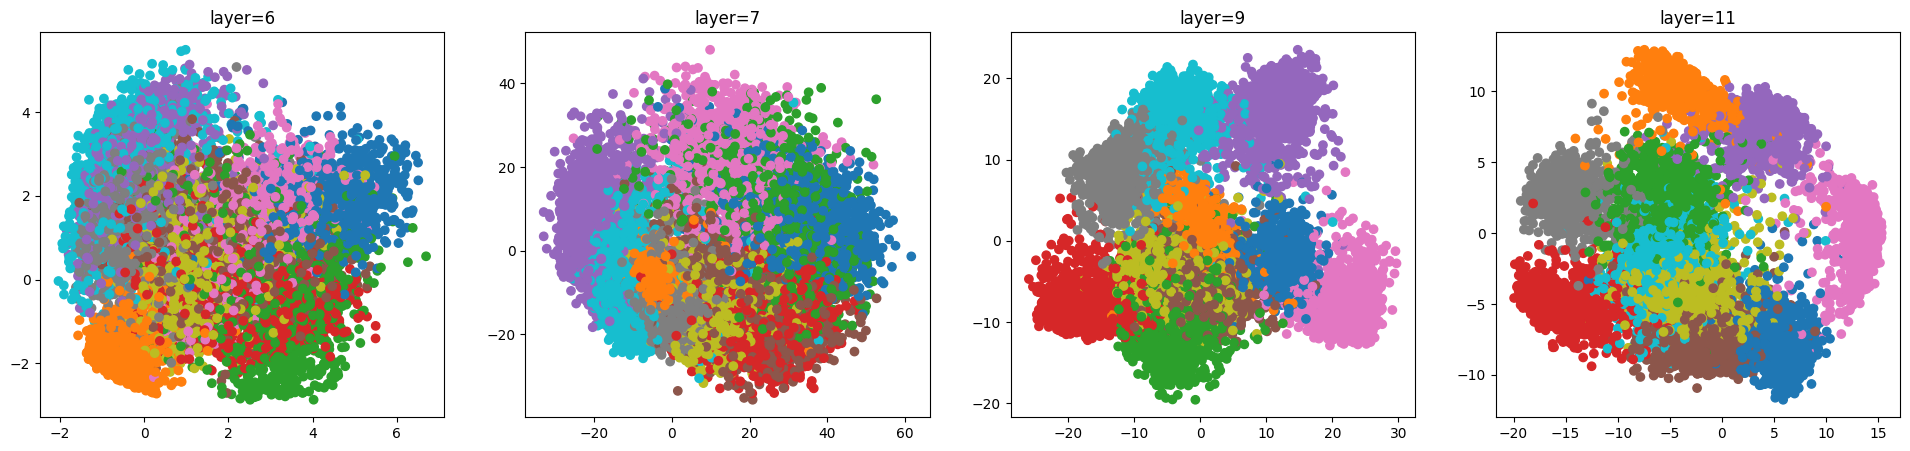

In [9]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

fig, ax = plt.subplots(1, 4, figsize=(24, 5))
for idx, layer in enumerate(monitored_layers):
    pca.fit(activations[layer].numpy())
    components = torch.tensor(pca.components_)
    projection = torch.mm(activations[layer], components.T)

    ax[idx].scatter(projection[:,0], projection[:,1], c=targets, cmap='tab10')
    ax[idx].set_title(f"{layer=}")

In [10]:
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from IPython.display import clear_output, display


class ProjectionPlotter:
    def __init__(self, nplots: int, layout: tuple = None):
        self.nplots = nplots
        self.layout = layout
        self.pca = PCA(n_components=2)
        self.loss = []
        self._initialize_fig()
        
        
    def __call__(self, activations: torch.Tensor, targets: List[int], loss: int):
        assert len(activations) == self.nplots - 1
        assert len(targets) == activations[0].shape[0]
        self.loss.append(loss)
        
        for i in range(1, self.nplots):
            projections = self._transform(activations[i-1])
            self._scatter(vars(self)['ax'+str(i)], projections, targets)
        self._plot(vars(self)['ax'+str(self.nplots)], self.loss)
        
        clear_output(wait=True)
        display(self.fig)
    
    @staticmethod 
    def _scatter(axis, projections: torch.Tensor, targets: List[int]):
        axis.clear()
        axis.scatter(projections[:,0], projections[:,1], c=targets, cmap='tab10')
    
    @staticmethod   
    def _plot(axis, loss: List):
        axis.clear()
        axis.plot(loss)
    
    def _transform(self, data: torch.Tensor):
        self.pca.fit(data.numpy())
        components = torch.tensor(self.pca.components_)
        projections = torch.mm(data, components.T)
        return projections

    def _initialize_fig(self):
        if self.layout is None:
            self.layout = (1, self.nplots)
        self.fig = plt.figure(figsize=(6*self.layout[1],5*self.layout[0]))
        for i in range(1, self.nplots+1):
            vars(self)['ax'+str(i)] = self.fig.add_subplot(*self.layout, i)
    

In [11]:
import transformations
from transformations import Scale, Identity, ToVector
from loading import TripletLoader
from layers import AdaptationModule
from initialization import IdentityInitializer, RandomInitializer

In [24]:
layer = 7
layer_dim = 120

nepochs = 20
nbatches = 100
batch_size = 64

lr = 0.1
margin = 1.0

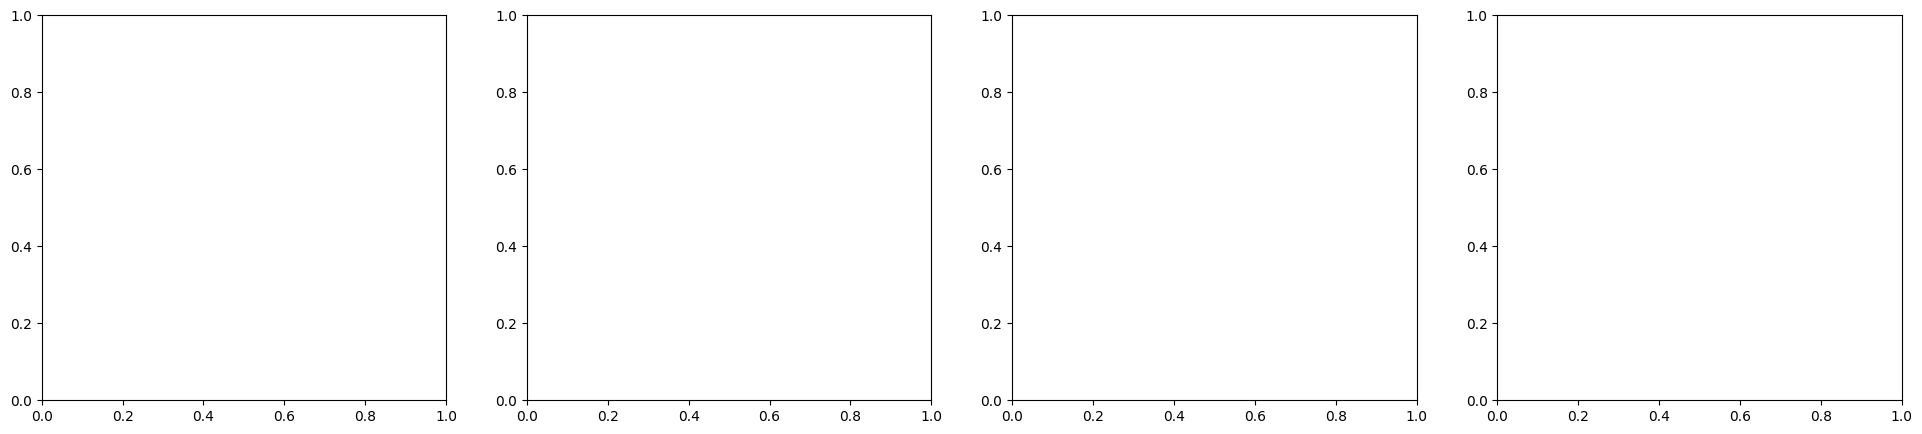

In [25]:
# for training
adaptation_layer1 = AdaptationModule(layer_dim, IdentityInitializer(), lr=lr, margin=margin)
adaptation_layer2 = AdaptationModule(layer_dim, IdentityInitializer(), lr=lr, margin=margin)
triplet_loader = TripletLoader(mnist_data, transforms=Unsqueeze())

In [ ]:
# for testing
from testing import ModuleTester
plotter = ProjectionPlotter(4)
#tester = ModuleTester(mnist_test_data, transforms=embedding)

In [14]:
def test_layers(test_inputs, layers):
    test_outputs = []
    test_outputs.append(test_inputs)
    for layer in layers:
        layer.test_mode('on')
        layer_outputs = torch.empty(0)
        for inp in test_inputs:
            out = layer(inp.unsqueeze(0))
            layer_outputs = torch.cat((layer_outputs, out), dim=0)
        test_outputs.append(layer_outputs)
        layer.test_mode('off')
    return test_outputs

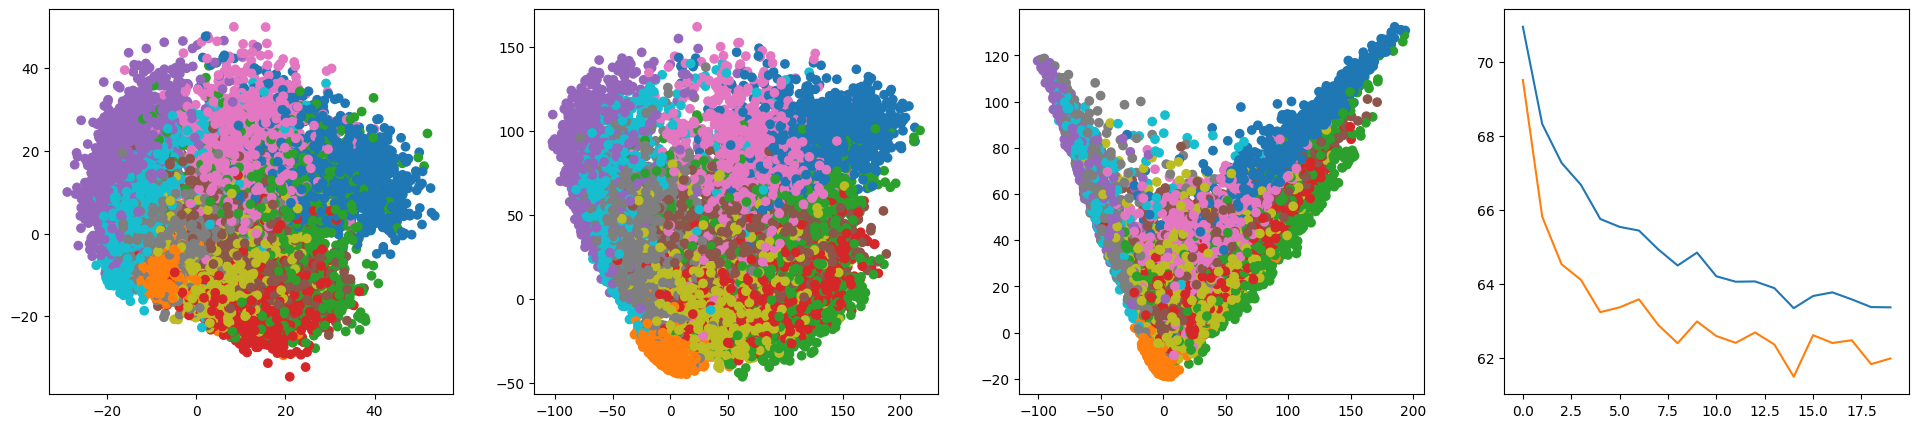

In [26]:
#training loop
for epoch in range(nepochs):
    batch_loss1, batch_loss2 = 0, 0
    for batches in tqdm(range(nbatches), desc=f"Epoch:{epoch+1}/{nepochs}"):
        for x in triplet_loader(batch_size):
            x = embeddings(x)[layer]
            x = adaptation_layer1(x)
            x = adaptation_layer2(x)
            
        batch_loss1 += adaptation_layer1.loss/batch_size
        batch_loss2 += adaptation_layer2.loss/batch_size
        
        adaptation_layer1.organize()
        adaptation_layer2.organize()
    test_outputs = test_layers(activations[layer], [adaptation_layer1, adaptation_layer2])
    plotter(test_outputs, targets, [batch_loss1, batch_loss2])

In [29]:
test_outputs[0]

tensor([[ 0.5151,  5.4608, -3.4740,  ..., -8.2170,  4.2536,  1.4043],
        [-3.6089, -0.7899, -2.2688,  ..., -1.7023,  9.4763,  4.0708],
        [-4.3805, -1.4011, -3.3963,  ..., -6.1781,  4.9259,  3.5607],
        ...,
        [-3.4027,  4.0689,  3.7890,  ..., -1.3585,  3.2737,  5.6336],
        [-4.0160,  4.5026, -6.4059,  ..., -8.4969, 12.0685,  2.5243],
        [-2.1041,  3.7162, -0.2752,  ..., -0.8608,  0.7792,  0.3924]])

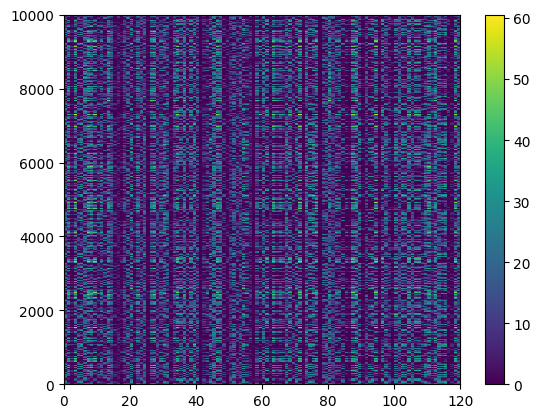

In [33]:
plt.pcolormesh(test_outputs[1])
plt.colorbar()

In [25]:
from layers import DiscriminationModule, AdaptationModule
from initialization import DatasetInitializer, RandomInitializer
from loading import SequentialLoader

transform = transformations.Compose([Scale(), ToVector()])
triplet_loader_dc = TripletLoader(mnist_data, transforms=transform)
#loader = SequentialLoader(mnist_data, transforms=transform)

layer1 = DiscriminationModule(500, DatasetInitializer(mnist_data, transforms=transform), beta=0.98)
layer2 = AdaptationModule(500, IdentityInitializer(), lr=0.01)
layer3 = AdaptationModule(500, IdentityInitializer(), lr=0.01)

In [26]:
nepochs = 20
nbatches = 100
batch_size = 64
for epoch in range(nepochs):
    batch_loss1, batch_loss2 = 0.0, 0.0
    for batches in tqdm(range(nbatches), desc=f"Epoch:{epoch+1}/{nepochs}"):
        for x in triplet_loader_dc(batch_size):
            x = layer1(x)
            x = layer2(x)
            x = layer3(x)
            
        batch_loss1 += adaptation_layer1.loss/batch_size
        batch_loss2 += adaptation_layer2.loss/batch_size
        
        layer1.organize()
        layer2.organize()
        layer3.organize()
        
    test_outputs = test_layers(activations[layer], [adaptation_layer1, adaptation_layer2])
    plotter(test_outputs, targets, [batch_loss1, batch_loss2])

100%|██████████| 100/100 [1:00:27<00:00, 36.27s/it]


In [28]:
nepochs = 1
nbatches = 100
batch_size = 64
lr = 0.01

weights = torch.randn(500, 500)

for epoch in range(nepochs):
    for batches in tqdm(range(nbatches), desc=f"Epoch:{epoch+1}/{nepochs}"):
        grad = torch.zeros(500, 500)
        for triplet in triplet_loader_dc(batch_size):
            anc = triplet[0]
            pos = triplet[1]
            neg = triplet[2]
            
            emb_anc = dcnet(anc)
            emb_pos = dcnet(pos)
            emb_neg = dcnet(neg)
            
            grad += siamese_grad(weights, [emb_anc, emb_pos, emb_neg])
        weights += lr*grad/batch_size

Epoch:1/1: 100%|██████████| 100/100 [58:19<00:00, 34.99s/it]


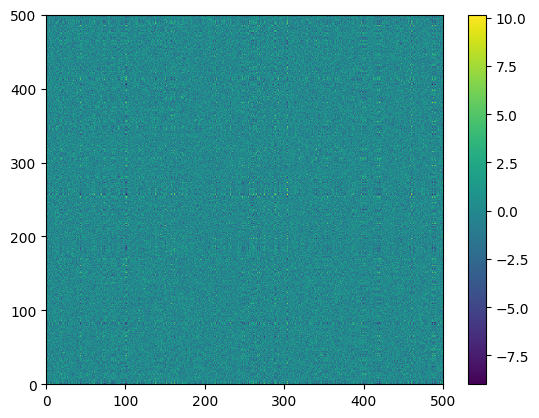

In [29]:
plt.pcolormesh(weights)
plt.colorbar()

In [30]:
test_loader = DataLoader(mnist_test_data, shuffle=True)
targets = []
activations = torch.empty(0)
transformed_activations = torch.empty(0)
for idx, data in tqdm(enumerate(test_loader), total=len(test_loader)):
        input, target = data
        targets.append(target.item())
        input = transform(input)
        output = dcnet(input)
        tranformed_output = torch.mm(output, weights)
        activations = torch.cat((activations, output), dim=0)
        transformed_activations = torch.cat((transformed_activations, tranformed_output), dim=0)
        
        if idx >= 2000:
                break        

 20%|██        | 2000/10000 [06:16<25:06,  5.31it/s]  


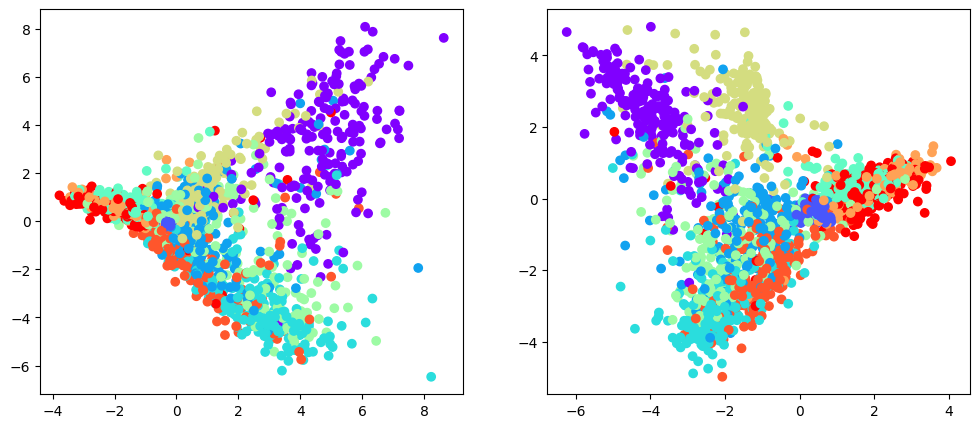

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

pca.fit(activations.numpy())
components = torch.tensor(pca.components_)
projection = torch.mm(activations, components.T)
ax[0].scatter(projection[:,0], projection[:,1], c=targets, cmap='rainbow')

pca.fit(transformed_activations.numpy())
components = torch.tensor(pca.components_)
projection = torch.mm(activations, components.T)
ax[1].scatter(projection[:,0], projection[:,1], c=targets, cmap='rainbow')

In [44]:
import torch
z = torch.randn(5, 5)
x = torch.tensor([True]*5)
print(x.shape)
for i in range(2):
    y = torch.rand(1,5)
    print(f"{y=}")
    x = x.logical_and(y>0.5)
print(f"{x=}")
z = x.T*z
print(f"{z=}")

torch.Size([5])
y=tensor([[0.5585, 0.6034, 0.6698, 0.8414, 0.0723]])
y=tensor([[0.2456, 0.5308, 0.5165, 0.7227, 0.0877]])
x=tensor([[False,  True,  True,  True, False]])
z=tensor([[-0.0000, -0.0000,  0.0000,  0.0000,  0.0000],
        [-0.1455,  0.4452,  0.9992, -0.4166, -0.2052],
        [ 0.0753, -0.3393, -0.1401, -0.0321, -1.0989],
        [ 1.5094,  1.2999,  0.3888, -0.2095,  2.1291],
        [ 0.0000, -0.0000, -0.0000, -0.0000,  0.0000]])


1
2
3


{'ax1': 0, 'ax2': 0, 'ax3': 0}

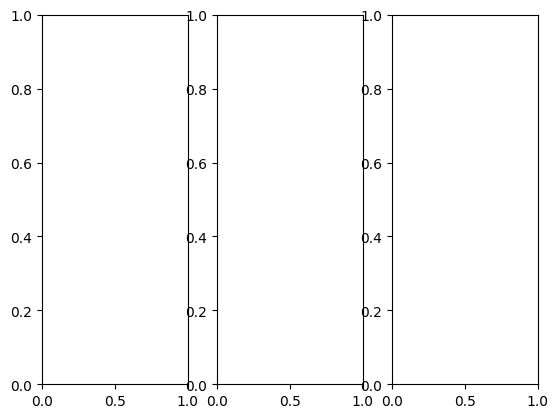

In [29]:
d = {}
def test_layout(fig, nplots, layout = None):
    if layout is not None:
        for i in range(1, nplots+1):
            print(i)
            fig.add_subplot(*layout, i)
            d['ax'+str(i)] = 0
        
fig = plt.figure()
test_layout(fig, 3, (1, 3))
d